# Test of Optimizers for MobileNetV2 CNN

This notebook provides the tools to train a Convolutional Neural Network (CNN) based on the MobileNetV2 architecture and to test different combinations of optimizers and learning rates to find which setup performs best.

Specifically, the notebook is configured to experiment with the following learning rates and optimizers:

Learning rates: 1e-2, 1e-4

Optimizers:

- Adam

- AdamW (with weight decay)

- RMSprop (with momentum)

- Adagrad

- SGD (with momentum)

You can train the model using the preprocessed dataset provided (a subset of the BirdCLEF 2021 competition), available in the repository files.

Alternatively, you may use the original BirdCLEF 2021 audio dataset or other audio datasets, but in that case, you will first need to convert all audio files into Mel-Spectrogram representations and prepare the data using the other Jupyter notebooks.

The model is designed to learn from relatively short and centered audio fragments. If you use different data or change the trimming logic, ensure that bird vocalizations are not being lost or misaligned.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import time

dir = '/content/drive/Shared drives/Deep Learning Group G/UPF_Deep_Learning_2025/Final Project/Birdclef2021/' # your path.
os.chdir(dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class BirdSpectrogramDataset(Dataset):
    def __init__(self, csv_path, npy_folder, transform=None):
        self.npy_folder = npy_folder
        self.transform = transform

        # Load CSV
        data = pd.read_csv(csv_path)

        # List of .npy filenames in the folder
        npy_files = set(os.listdir(npy_folder))

        # Filter CSV to only keep rows where filename.ogg.npy exists
        filtered_rows = []
        for _, row in data.iterrows():
            filename = row['filename'] + '.npy'  # e.g., XC618945.ogg.npy
            if filename in npy_files:
                filtered_rows.append(row)

        # Create final DataFrame
        self.data = pd.DataFrame(filtered_rows)

        print(f"Loaded {len(self.data)} valid entries out of {len(data)} total")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        npy_filename = row['filename'] + '.npy'
        npy_path = os.path.join(self.npy_folder, npy_filename)

        spectrogram = np.load(npy_path)  # shape: (12, mel_bins, time)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        label = torch.tensor(row['label_id'], dtype=torch.long)
        return spectrogram, label

In [ ]:
# Paths
LABELS_CSV = dir + "update_metadata1.csv"
DATA_DIR = dir + "train_good/"

# Create dataset and dataloader
dataset = BirdSpectrogramDataset(csv_path=LABELS_CSV, npy_folder=DATA_DIR)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the split ratio
val_ratio = 0.3  # 30% for validation
total_size = len(dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create separate dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# Visualize one batch
for X, y in val_loader:
    print(X.shape)  # Expected shape: (B, 12, mel_bins, time)
    print(y)        # Expected shape: (B,)
    break

Loaded 587 valid entries out of 2892 total
torch.Size([16, 10, 128, 321])
tensor([3, 4, 2, 4, 0, 0, 2, 2, 5, 1, 2, 0, 1, 2, 4, 2])


The Model (CNN)

In [ ]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size=1, stride=1))
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, kernel_size=3, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MyEfficientCNN_MobileNetV2(nn.Module):
    def __init__(self, num_classes=10):
        super(MyEfficientCNN_MobileNetV2, self).__init__()
        input_channel = 16
        last_channel = 128

        # Configuración MobileNetV2

        settings = [
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 2, 2],
            [6, 64, 1, 1]
        ]

        #First layer with 32x32 input
        layers = [ConvBNReLU(10, input_channel, kernel_size=3, stride=1)]

        #Rest of layers
        for t, c, n, s in settings:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, c, stride, expand_ratio=t))
                input_channel = c

        #Last Layer
        layers.append(ConvBNReLU(input_channel, last_channel, kernel_size=1, stride=1))
        self.conv_layers = nn.Sequential(*layers) #El * en (*layers) es el desempaquetado de la lista, equivale a escribir nn.Sequential(layer1, layer2, layer3, ...), como lo hacemos dinamicamente es mejor con el *.



        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(last_channel, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
def train(model, loader, loss_function, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = train_loss / total
    epoch_acc = correct / total
    train_time = time.time() - start_time
    return epoch_loss, epoch_acc, train_time

def evaluate(model, loader, loss_function, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = val_loss / total
    epoch_acc = correct / total
    val_time = time.time() - start_time
    return epoch_loss, epoch_acc, val_time

def compute_model_params(model: nn.Module) -> int:
    """
    Computes the total number of trainable parameters in a PyTorch model.

    Also issues a warning if the number of parameters exceeds a defined threshold.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        max_params (int, optional): Maximum allowed parameters before warning is triggered. Default is 150,000.

    Returns:
        int: Total number of trainable parameters in the model.
    """
    total_params = 0

    # Iterate through all parameters and sum their sizes
    for param in model.parameters():
        total_params += param.numel()

    return total_params

Device: cuda

 Training with Adam | lr=0.01
Epoch  1 | Train Acc: 0.1436 | Train Loss: 1.9013 | Val Acc: 0.1307 | Val Loss: 4.7189
Epoch  2 | Train Acc: 0.1946 | Train Loss: 1.8425 | Val Acc: 0.1932 | Val Loss: 1.8810
Epoch  3 | Train Acc: 0.1679 | Train Loss: 1.8064 | Val Acc: 0.1875 | Val Loss: 1.9650
Epoch  4 | Train Acc: 0.2457 | Train Loss: 1.7310 | Val Acc: 0.2273 | Val Loss: 1.8635
Epoch  5 | Train Acc: 0.2847 | Train Loss: 1.7204 | Val Acc: 0.1818 | Val Loss: 2.3414
Epoch  6 | Train Acc: 0.3285 | Train Loss: 1.6058 | Val Acc: 0.2045 | Val Loss: 1.9622
Epoch  7 | Train Acc: 0.3090 | Train Loss: 1.6034 | Val Acc: 0.2386 | Val Loss: 1.9009
Epoch  8 | Train Acc: 0.3285 | Train Loss: 1.5192 | Val Acc: 0.2443 | Val Loss: 1.7781
Epoch  9 | Train Acc: 0.3625 | Train Loss: 1.5428 | Val Acc: 0.2557 | Val Loss: 1.6709
Epoch 10 | Train Acc: 0.3650 | Train Loss: 1.5530 | Val Acc: 0.2841 | Val Loss: 1.6773
Epoch 11 | Train Acc: 0.3747 | Train Loss: 1.4697 | Val Acc: 0.3068 | Val Loss: 1.6116

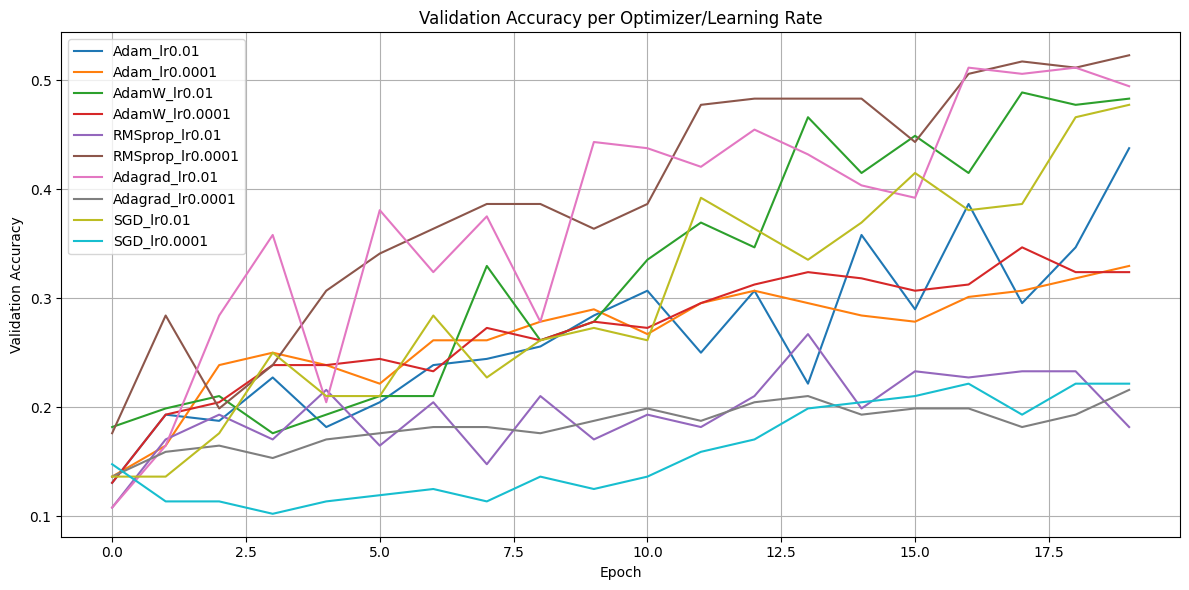

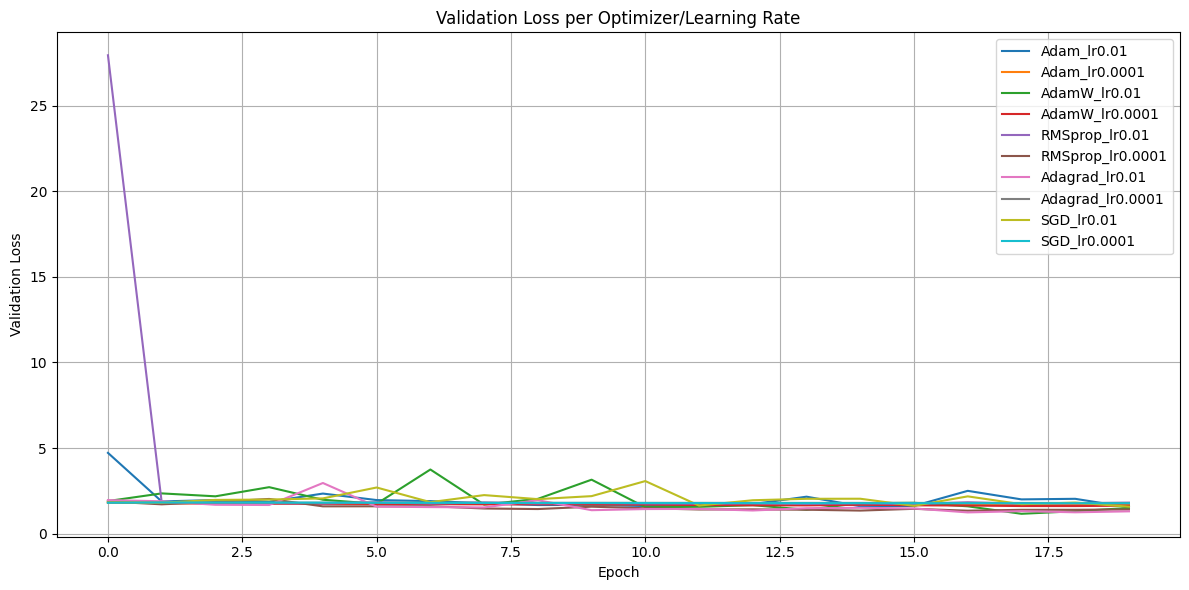

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_epochs = 20
learning_rates = [1e-2, 1e-4]
optimizers_dict = {
    "Adam": lambda params, lr: torch.optim.Adam(params, lr=lr),
    "AdamW": lambda params, lr: torch.optim.AdamW(params, lr=lr, weight_decay=1e-4),
    "RMSprop": lambda params, lr: torch.optim.RMSprop(params, lr=lr, momentum=0.9),
    "Adagrad": lambda params, lr: torch.optim.Adagrad(params, lr=lr),
    "SGD": lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.9),
}

results_acc = {}
results_loss = {}
results_train_acc = {}
results_train_loss = {}


for opt_name, opt_func in optimizers_dict.items():
    for lr in learning_rates:
        print(f"\n Training with {opt_name} | lr={lr}")

        model = MyEfficientCNN_MobileNetV2(num_classes=6).to(device)
        optimizer = opt_func(model.parameters(), lr)
        loss_function = nn.CrossEntropyLoss()

        val_accuracies = []
        val_losses = []
        train_accuracies = []
        train_losses = []

        for epoch in range(num_epochs):
            train_loss, train_acc, train_time = train(model, train_loader, loss_function, optimizer, device)
            val_loss, val_acc, val_time = evaluate(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

        key = f"{opt_name}_lr{lr}"
        results_acc[key] = val_accuracies
        results_loss[key] = val_losses
        results_train_acc[key] = train_accuracies
        results_train_loss[key] = train_losses


plt.figure(figsize=(12, 6))
for key, accs in results_acc.items():
    plt.plot(accs, label=key)
plt.title("Validation Accuracy per Optimizer/Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for key, losses in results_loss.items():
    plt.plot(losses, label=key)
plt.title("Validation Loss per Optimizer/Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

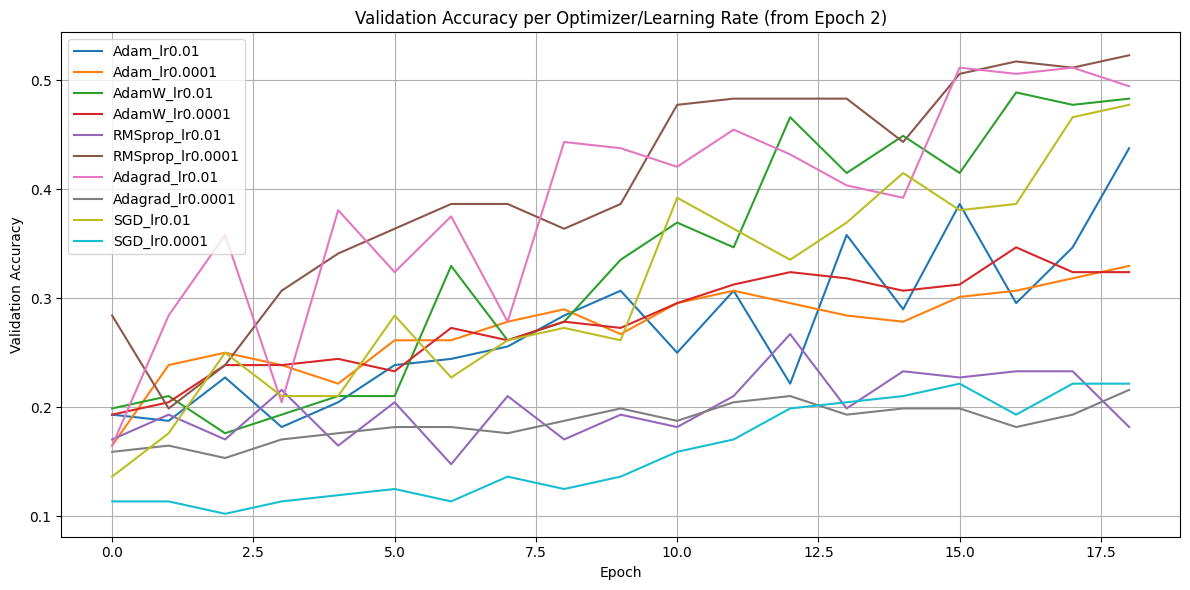

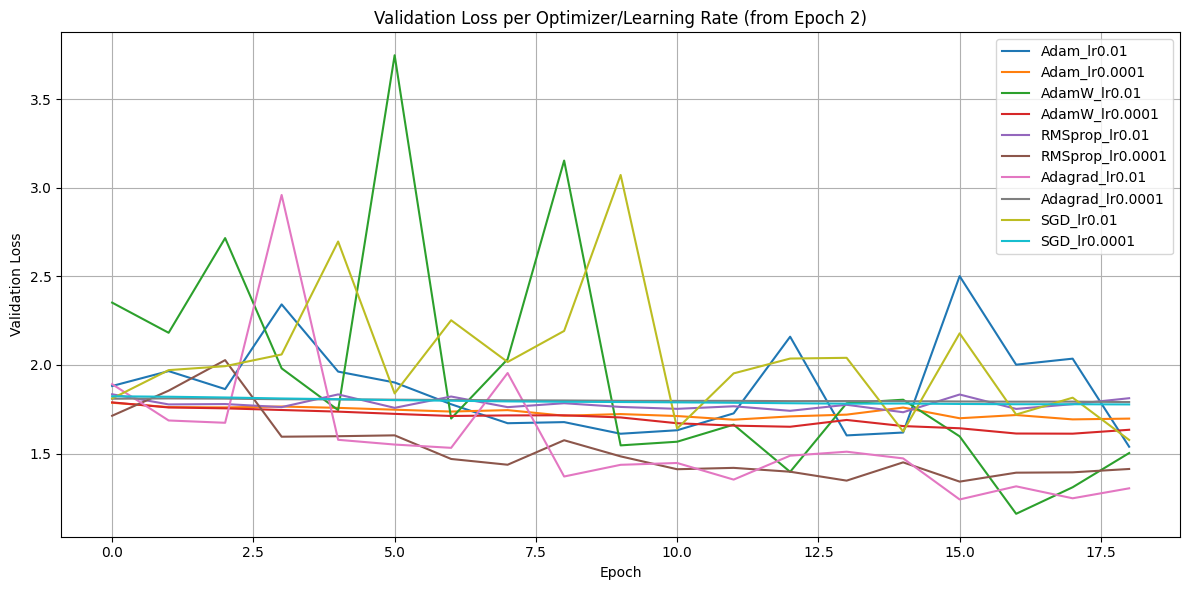

In [ ]:
plt.figure(figsize=(12, 6))
for key, accs in results_acc.items():
    plt.plot(accs[1:], label=key)  # Excluye la primera epoch
plt.title("Validation Accuracy per Optimizer/Learning Rate (from Epoch 2)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss sin la primera epoch
plt.figure(figsize=(12, 6))
for key, losses in results_loss.items():
    plt.plot(losses[1:], label=key)  # Excluye la primera epoch
plt.title("Validation Loss per Optimizer/Learning Rate (from Epoch 2)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Define the specific key you're interested in
target_key = "AdamW_lr0.01"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].plot(results_acc[target_key], label="Validation Accuracy", color='blue', marker='o')
axes[0].set_title(f"Accuracy: {target_key}")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(results_loss[target_key], label="Validation Loss", color='red', marker='o')
axes[1].set_title(f"Loss: {target_key}")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()


plt.suptitle(f"Training Metrics for {target_key}", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

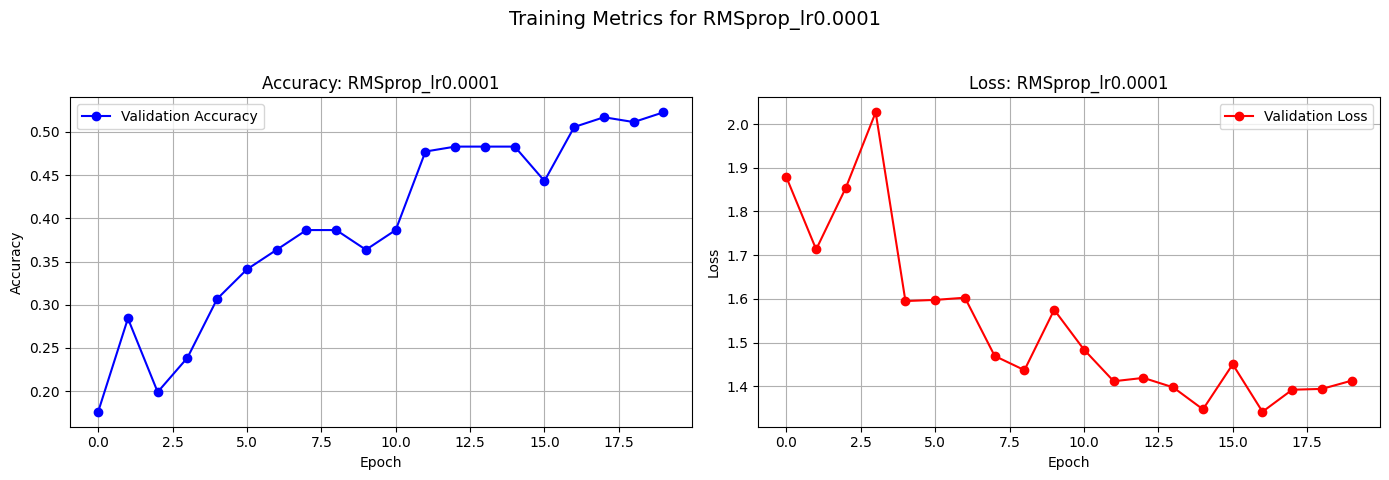

In [ ]:
import matplotlib.pyplot as plt

# Datos extraídos del entrenamiento
results_acc = {
    "RMSprop_lr0.0001": [
        0.1761, 0.2841, 0.1989, 0.2386, 0.3068,
        0.3409, 0.3636, 0.3864, 0.3864, 0.3636,
        0.3864, 0.4773, 0.4830, 0.4830, 0.4830,
        0.4432, 0.5057, 0.5170, 0.5114, 0.5227
    ]
}

results_loss = {
    "RMSprop_lr0.0001": [
        1.8782, 1.7131, 1.8547, 2.0269, 1.5949,
        1.5976, 1.6026, 1.4693, 1.4368, 1.5749,
        1.4839, 1.4114, 1.4191, 1.3974, 1.3471,
        1.4502, 1.3416, 1.3920, 1.3939, 1.4128
    ]
}

# Clave del optimizador
target_key = "RMSprop_lr0.0001"

# Crear figura y subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de Accuracy
axes[0].plot(results_acc[target_key], label="Validation Accuracy", color='blue', marker='o')
axes[0].set_title(f"Accuracy: {target_key}")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Gráfico de Loss
axes[1].plot(results_loss[target_key], label="Validation Loss", color='red', marker='o')
axes[1].set_title(f"Loss: {target_key}")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Título general
plt.suptitle(f"Training Metrics for {target_key}", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

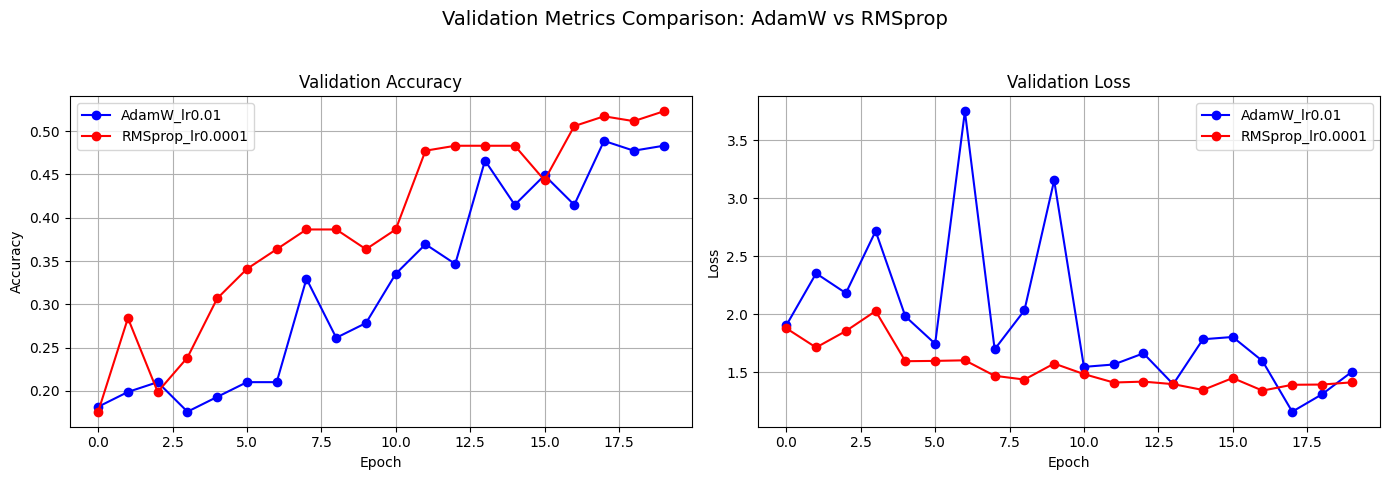

In [ ]:
import matplotlib.pyplot as plt

# Optimizers a comparar
target_keys = ["AdamW_lr0.01", "RMSprop_lr0.0001"]

# Accuracy de validación
results_acc = {
    "RMSprop_lr0.0001": [
        0.1761, 0.2841, 0.1989, 0.2386, 0.3068,
        0.3409, 0.3636, 0.3864, 0.3864, 0.3636,
        0.3864, 0.4773, 0.4830, 0.4830, 0.4830,
        0.4432, 0.5057, 0.5170, 0.5114, 0.5227
    ],
    "AdamW_lr0.01": [
        0.1818, 0.1989, 0.2102, 0.1761, 0.1932,
        0.2102, 0.2102, 0.3295, 0.2614, 0.2784,
        0.3352, 0.3693, 0.3466, 0.4659, 0.4148,
        0.4489, 0.4148, 0.4886, 0.4773, 0.4830
    ]
}

# Pérdida de validación
results_loss = {
    "RMSprop_lr0.0001": [
        1.8782, 1.7131, 1.8547, 2.0269, 1.5949,
        1.5976, 1.6026, 1.4693, 1.4368, 1.5749,
        1.4839, 1.4114, 1.4191, 1.3974, 1.3471,
        1.4502, 1.3416, 1.3920, 1.3939, 1.4128
    ],
    "AdamW_lr0.01": [
        1.9045, 2.3514, 2.1812, 2.7155, 1.9805,
        1.7450, 3.7469, 1.6975, 2.0325, 3.1528,
        1.5460, 1.5666, 1.6628, 1.3966, 1.7839,
        1.8036, 1.5969, 1.1600, 1.3097, 1.5028
    ]
}

# Colores por optimizador
colors = {
    "AdamW_lr0.01": "blue",
    "RMSprop_lr0.0001": "red"
}

# Crear figura
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de Accuracy
for key in target_keys:
    axes[0].plot(results_acc[key], label=f"{key}", color=colors[key], marker='o')

axes[0].set_title("Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Gráfico de Loss
for key in target_keys:
    axes[1].plot(results_loss[key], label=f"{key}", color=colors[key], marker='o')

axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True)
axes[1].legend()

# Título general
plt.suptitle("Validation Metrics Comparison: AdamW vs RMSprop", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()